#  Testing the final model on multiple time periods

See how well the model performs on more recent data

In [1]:
import os

from shapely.geometry import Point
import geopandas as gpd
import contextily as cx
import pandas as pd
#from eli5.sklearn import PermutationImportance
import joblib

from sklearn.metrics import make_scorer, mean_absolute_error, r2_score, mean_squared_error

api = "6c2695a3-768a-4885-a408-5770a99f5269"

from Functions import *

/opt/homebrew/anaconda3/envs/py310/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(


In [2]:
buffer_size_m=400

## Load the fitted model

In [3]:
rf_model_pipeline1 = joblib.load('Results/FinalModels/rf_model_pipeline1_{}_outlierremovaleachsensor.pkl'.format(buffer_size_m))
# rf_model_pipeline2 = joblib.load('Results/FinalModels/rf_model_pipeline2_{}.pkl'.format(buffer_size_m))
# rf_model_pipeline3 = joblib.load('Results/rf_model_pipeline3_combined_features.fit.sav')

## Load the data to test the model

In [4]:
# Need an amended prepare_x_y_data function that retains the datetime column so we can work out
# the indices for data in 2022. The original is in the Functions.py file
def prepare_x_y_data2(input_csv):
    # Read in formatted data
    data = pd.read_csv(input_csv, index_col = False)
    data = data.fillna(0)

    # Drop unneeded (mostly string) columns
    data = drop_unneeded_columns(data)

    # Get rid of columns in which none of the sensors have a value
    for column in data.columns:
        if np.nanmax(data[column]) ==0:
            del data[column]

    # Filter columns using the regex pattern in function input
    regex_pattern = 'buildings$|street_inf$|landmarks$'
    data = data[data.columns.drop(list(data.filter(regex=regex_pattern)))].copy()

    ### Add a random variable (to compare performance of other variables against)
    rng = np.random.RandomState(seed=42)
    data['random'] = np.random.random(size=len(data))
    data["random_cat"] = rng.randint(3, size=data.shape[0])

    ## Prepare data for modelling
    ### Split into predictor/predictand variables
    Xfull = data.drop(['hourly_counts'], axis =1)
    Yfull = data['hourly_counts'].values

    ### Store the (non Sin/Cos) time columns and then remove them (Need them later to segment the results by hour of the day)
    data_time_columns = Xfull[['day_of_month_num', 'time', 'weekday_num', 'time_of_day', 'datetime']]
    Xfull = Xfull.drop(['day_of_month_num', 'time', 'weekday_num', 'time_of_day','month_num'],axis=1)
    # (Note: have kept datetime column!

    return Xfull, Yfull, data_time_columns

In [5]:
input_csv = "../Cleaned_data/FormattedDataForModelling/formatted_data_for_modelling_allsensors_{}_outlierremovaleachsensor.csv".format(buffer_size_m)
_Xfull, _Yfull, _data_time_columns = prepare_x_y_data2(input_csv)

# (NOTE: underscores are to denote global variables that should not be
# confused with model-specific ones later)

temp = pd.read_csv(input_csv)
_datetimes = temp['datetime']
_sensor_ids = temp['sensor_id']
del temp

/var/folders/bx/3j5z8qc50wl1tcff6xvbf2zh0000gs/T/ipykernel_96081/1462808028.py:5: DtypeWarning: Columns (5,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(input_csv, index_col = False)
/var/folders/bx/3j5z8qc50wl1tcff6xvbf2zh0000gs/T/ipykernel_96081/436144243.py:7: DtypeWarning: Columns (5,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  temp = pd.read_csv(input_csv)


## Create data slices for different time periods


Split the data into a few different time periods

In [6]:
time_periods = [
    ("Pre-Covid 1", '2020-01-01', '2020-03-01'),
    ("Starting Covid", '2020-03-01', '2020-04-01'),
    ("During Covid (2020)", '2020-04-01', '2021-01-01'),
    ("During Covid (2021)", '2021-01-01', '2022-01-01'),
    ("Post-Covid (2022)", '2022-01-01', '2023-01-01'),
    #("Post-Covid (2023)", '2023-01-01', '2024-01-01'),
    #("Post-Covid (2024)", '2024-01-01', '2025-01-01'),
]

I'm going to use a class to keep the results and data organised.

In [7]:
from typing import ClassVar
from dataclasses import dataclass

@dataclass
class Model():

    # Required arguments
    name: str
    Xfull: pd.DataFrame
    Yfull: np.ndarray
    datetimes: pd.Series
    sensor_ids: pd.Series

    # We calculate the following post-init
    y_pred: np.ndarray = None
    mae_score: float = None
    r2_score: float = None
    rmse_score: float = None
    neg_mae_score: float = None

    # Class variable
    rf_model_pipeline: ClassVar[Pipeline] = joblib.load(
        'Results/FinalModels/rf_model_pipeline1_{}_outlierremovaleachsensor.pkl'
        .format(buffer_size_m))

    def __post_init__(self):
        print(f"Running predictions for {self.name}")
        #self.Xfull.drop(columns=['day', 'datetime', 'year'])
        self.y_pred = Model.rf_model_pipeline.predict(self.Xfull)
        self.calc_errors()

    def calc_errors(self):
        self.mae_score = mean_absolute_error(self.Yfull, self.y_pred)
        self.r2_score = r2_score(self.Yfull, self.y_pred)
        self.rmse_score = mean_squared_error(self.Yfull, self.y_pred, squared=False)
        self.neg_mae_score = -1 * self.mae_score

    def print_scores(self):
        print(f"Scores for model '{self.name}'")
        print(f"\tMean absoloute error: {self.mae_score}")
        print(f"\tMean R2: {self.r2_score}")
        print(f"\tMean RMSE: {self.rmse_score}")


    #error_metrics: ClassVar[str] = ['neg_mean_absolute_error', 'r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_percentage_error']
# Store the models in a list
models = []

for (name, start, end) in time_periods:
    # Create the stuff needed for the model class
    time_indices = _Xfull.index[
        (pd.to_datetime(_Xfull['datetime']) >= start) &
        (pd.to_datetime(_Xfull['datetime']) < end)]

    m = Model(
        name=name,
        Xfull = _Xfull.iloc[time_indices].drop(
            columns=['day', 'datetime', 'year']).copy(),
        Yfull = _Yfull[time_indices].copy(),
        datetimes = _datetimes.iloc[time_indices].copy(),
        sensor_ids = _sensor_ids.iloc[time_indices].copy()
    )
    models.append(m)


Running predictions for Pre-Covid 1
Running predictions for Starting Covid
Running predictions for During Covid (2020)
Running predictions for During Covid (2021)
Running predictions for Post-Covid (2022)


### Validate the model

(Most of this comes from script "3. ModelEvaluation.ipynb")

Print scores:

In [8]:
for m in models:
    m.print_scores()



Scores for model 'Pre-Covid 1'
	Mean absoloute error: 146.39928108235938
	Mean R2: 0.8567970082705059
	Mean RMSE: 280.710272697933
Scores for model 'Starting Covid'
	Mean absoloute error: 290.97369613389907
	Mean R2: 0.08911192866612094
	Mean RMSE: 551.6029844062671
Scores for model 'During Covid (2020)'
	Mean absoloute error: 465.9180427740822
	Mean R2: -7.535484672970897
	Mean RMSE: 782.4260153357712
Scores for model 'During Covid (2021)'
	Mean absoloute error: 407.4378507674161
	Mean R2: -2.6060484180512007
	Mean RMSE: 722.357945127844
Scores for model 'Post-Covid (2022)'
	Mean absoloute error: 306.6110036100586
	Mean R2: -0.23013324283972536
	Mean RMSE: 584.8076322758918


In [1]:
assert False, "Continue editing from here"

AssertionError: Continue editing from here

## Plot predicted vs actual values

In [23]:
results_dir = os.path.join("Results", "ModelTestPostCovid/")
os.makedirs(results_dir, exist_ok=True)

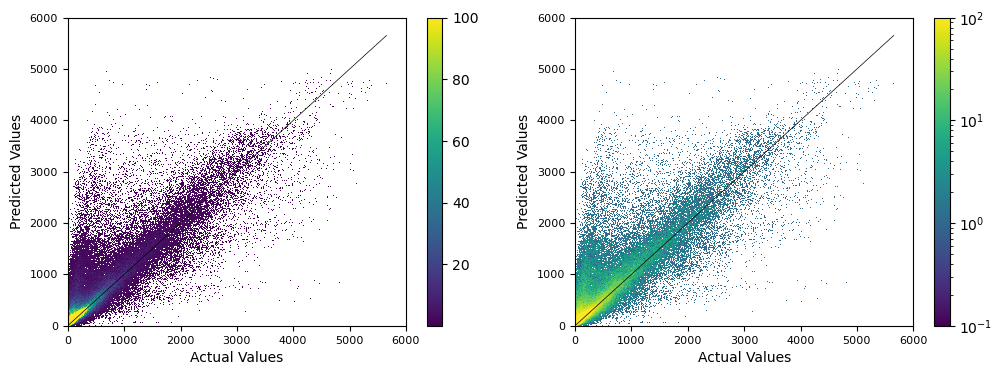

In [24]:
import datashader as ds
from datashader.mpl_ext import dsshow
fig, axs = plt.subplots(ncols=2, figsize = (12,4))

# Plot with linear scale
using_datashader(axs[0], Yfull, y_pred, 'linear')
axs[0].plot([Yfull.min(), Yfull.max()], [Yfull.min(), Yfull.max()], c='k', lw=0.5)
axs[0].set_ylabel("Predicted Values", size=10)
axs[0].set_xlabel("Actual Values", size=10)
axs[0].set_xlim([0, 6000])
axs[0].set_ylim([0, 6000])
axs[0].tick_params(axis='both', which='major', labelsize=8)

# Plot with log scale
using_datashader(axs[1], Yfull, y_pred, 'log')
axs[1].plot([Yfull.min(), Yfull.max()], [Yfull.min(), Yfull.max()], c='k', lw=0.5)
axs[1].set_ylabel("Predicted Values", size=10)
axs[1].set_xlabel("Actual Values", size=10)
axs[1].set_xlim([0, 6000])
axs[1].set_ylim([0, 6000])
axs[1].tick_params(axis='both', which='major', labelsize=8)

Just the log scale

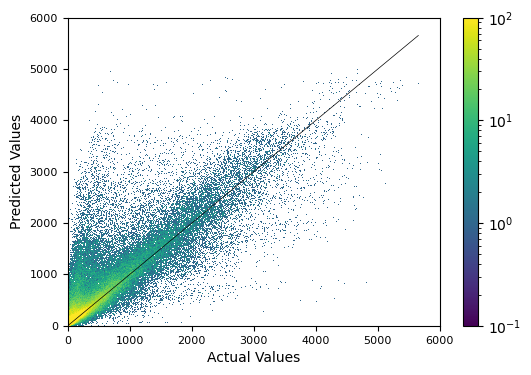

In [25]:
import datashader as ds
from datashader.mpl_ext import dsshow
fig, ax= plt.subplots(figsize = (6,4))

# Plot with log scale
using_datashader(ax, Yfull, y_pred, 'log')
ax.plot([Yfull.min(), Yfull.max()], [Yfull.min(), Yfull.max()], c='k', lw=0.5)
ax.set_ylabel("Predicted Values", size=10)
ax.set_xlabel("Actual Values", size=10)
ax.set_xlim([0, 6000])
ax.set_ylim([0, 6000]);
ax.tick_params(axis='both', which='major', labelsize=8)

fig.savefig(os.path.join(results_dir, "Predicted_vs_actual_values_log.png"))

## Find the error in the predictions broken down by hour and sensor

In [26]:
# Get all relevant data in one dataframe
df =pd.DataFrame({'Predictions': y_pred, 'Real_vals':Yfull, 'Hour': data_time_columns['time'],
                  'Weekday': data_time_columns['weekday_num']
                  ,'sensor_id': sensor_ids
                  ,'AbsolouteError':abs(Yfull - y_pred)
                  ,'Error':Yfull-y_pred, 'datetime':data_time_columns['datetime']})

# Add hour of week variable
df['hour_of_week'] = df.apply (lambda row: label_hour_of_week(row), axis=1)
# Sort by this variable
df=df.sort_values(by=['Weekday', 'Hour'])
df.head()

df['Percentage_Difference']= abs(df['Real_vals'] - df['Predictions'])/((df['Real_vals'] + df['Predictions'])/2)* 100
df['Percentage_Increase']= ((df['Real_vals'] - df['Predictions']) / abs(df['Predictions'])) * 100

In [27]:
df["datetime"]  = pd.to_datetime(df["datetime"] , errors='coerce')

In [28]:
df

Predictions  Real_vals  Hour  Weekday  sensor_id  AbsolouteError  \
2680448        71.77         58     0        1          1           13.77   
2680616        67.16         73     0        1          1            5.84   
2680784        78.55         90     0        1          1           11.45   
2680952       215.25        146     0        1          1           69.25   
2681120        73.83         96     0        1          1           22.17   
...              ...        ...   ...      ...        ...             ...   
3162565        97.38         17    23        7         64           80.38   
3162733        70.32          4    23        7         64           66.32   
3167940       617.65        109    23        7         65          508.65   
3168108       495.67         45    23        7         65          450.67   
3168276       487.77         22    23        7         65          465.77   

          Error            datetime hour_of_week  Percentage_Difference  \
2680448  -13.77 2020-01-06 00:00:00        w1_h0              21.222162   
2680616    5.84 2020-01-13 00:00:00        w1_h0               8.333333   
2680784   11.45 2020-01-20 00:00:00        w1_h0              13.586473   
2680952  -69.25 2020-01-27 00:00:00        w1_h0              38.339100   
2681120   22.17 2020-02-03 00:00:00        w1_h0              26.108461   
...         ...                 ...          ...                    ...   
3162565  -80.38 2020-03-22 23:00:00       w7_h23             140.549047   
3162733  -66.32 2020-03-29 23:00:00       w7_h23             178.471475   
3167940 -508.65 2020-03-15 23:00:00       w7_h23             139.998624   
3168108 -450.67 2020-03-22 23:00:00       w7_h23             166.707973   
3168276 -465.77 2020-03-29 23:00:00       w7_h23             182.737313   

         Percentage_Increase  
2680448           -19.186290  
2680616             8.695652  
2680784            14.576703  
2680952           -32.171893  
2681120            30.028444  
...                      ...  
3162565           -82.542617  
3162733           -94.311718  
3167940           -82.352465  
3168108           -90.921379  
3168276           -95.489678  

[122763 rows x 11 columns]

In [29]:

df.to_csv(os.path.join(results_dir, "model_postcovid_predictions_{}m.csv".format(buffer_size_m)),index=False)

In [30]:
def MAPE(Y_actual,Y_Predicted):
    try:
        mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    except:
        mape = np.nan
    return mape

df['Mape']  = df.apply(lambda x: MAPE(x['Real_vals'], x['Predictions']), axis=1)

In [31]:
# Lists to store errors for each hour/sensor
hourly_mapes = []
hourly_maes = []
hourly_mae_stds = []
hourly_means= []
hourly_stds= []

sensorly_mapes =[]
sensorly_maes =[]
sensorly_means = []

hourofweekly_mapes = []
hourofweekly_maes = []
hourofweekly_means= []
hourofweekly_stds= []
hourofweekly_mae_stds = []

# Loop through the hours and add the results to the list
for hour_of_week in df['hour_of_week'].unique():
    # print("At {} o'clock".format(hour))
    one_hour_of_week = df[df['hour_of_week'] ==hour_of_week]
    # print("Error is {}% of the average hourly count".format(round(one_hour['AbsolouteError'].mean()/one_hour['Real_vals'].mean()*100,1)))
    hourofweekly_mapes.append(one_hour_of_week['AbsolouteError'].mean()/one_hour_of_week['Real_vals'].mean()*100)
    hourofweekly_maes.append(round(one_hour_of_week['AbsolouteError'].mean(),1))
    hourofweekly_mae_stds.append(round(one_hour_of_week['AbsolouteError'].std(),1))
    hourofweekly_means.append(round(one_hour_of_week['Real_vals'].mean(),1))
    hourofweekly_stds.append(round(one_hour_of_week['Real_vals'].std(),1))

# Loop through the hours and add the results to the list
for hour in range(0,24):
    # print("At {} o'clock".format(hour))
    one_hour = df[df['Hour'] ==hour]
    # print("Error is {}% of the average hourly count".format(round(one_hour['AbsolouteError'].mean()/one_hour['Real_vals'].mean()*100,1)))
    hourly_mapes.append(one_hour['AbsolouteError'].mean()/one_hour['Real_vals'].mean()*100)
    hourly_maes.append(round(one_hour['AbsolouteError'].mean(),1))
    hourly_mae_stds.append(round(one_hour['AbsolouteError'].std(),1))
    hourly_means.append(round(one_hour['Real_vals'].mean(),1))
    hourly_stds.append(round(one_hour['Real_vals'].std(),1))

# Loop through the sensors and add the results to the list
for sensor_id in np.sort(sensor_ids.unique()):
    # print("At sensor {}".format(sensor_id))
    one_sensor = df[df['sensor_id'] ==sensor_id]
    # print("Error is {}% of the average hourly count".format(round(one_sensor['AbsolouteError'].mean()/one_sensor['Real_vals'].mean()*100,1)))
    sensorly_mapes.append(round(one_sensor['AbsolouteError'].mean()/one_sensor['Real_vals'].mean()*100,1))
    sensorly_maes.append(round(one_sensor['AbsolouteError'].mean(),1))
    sensorly_means.append(one_sensor['Real_vals'].mean())

### Plot the errors per hour of week

In [32]:
labels = ['1am','2am','3am','4am','5am','6am','7am','8am','9am','10am','11am','12',
         '1pm','2pm','3pm','4pm','5pm','6pm','7pm','8pm','9pm','10pm','11pm','12',]*7

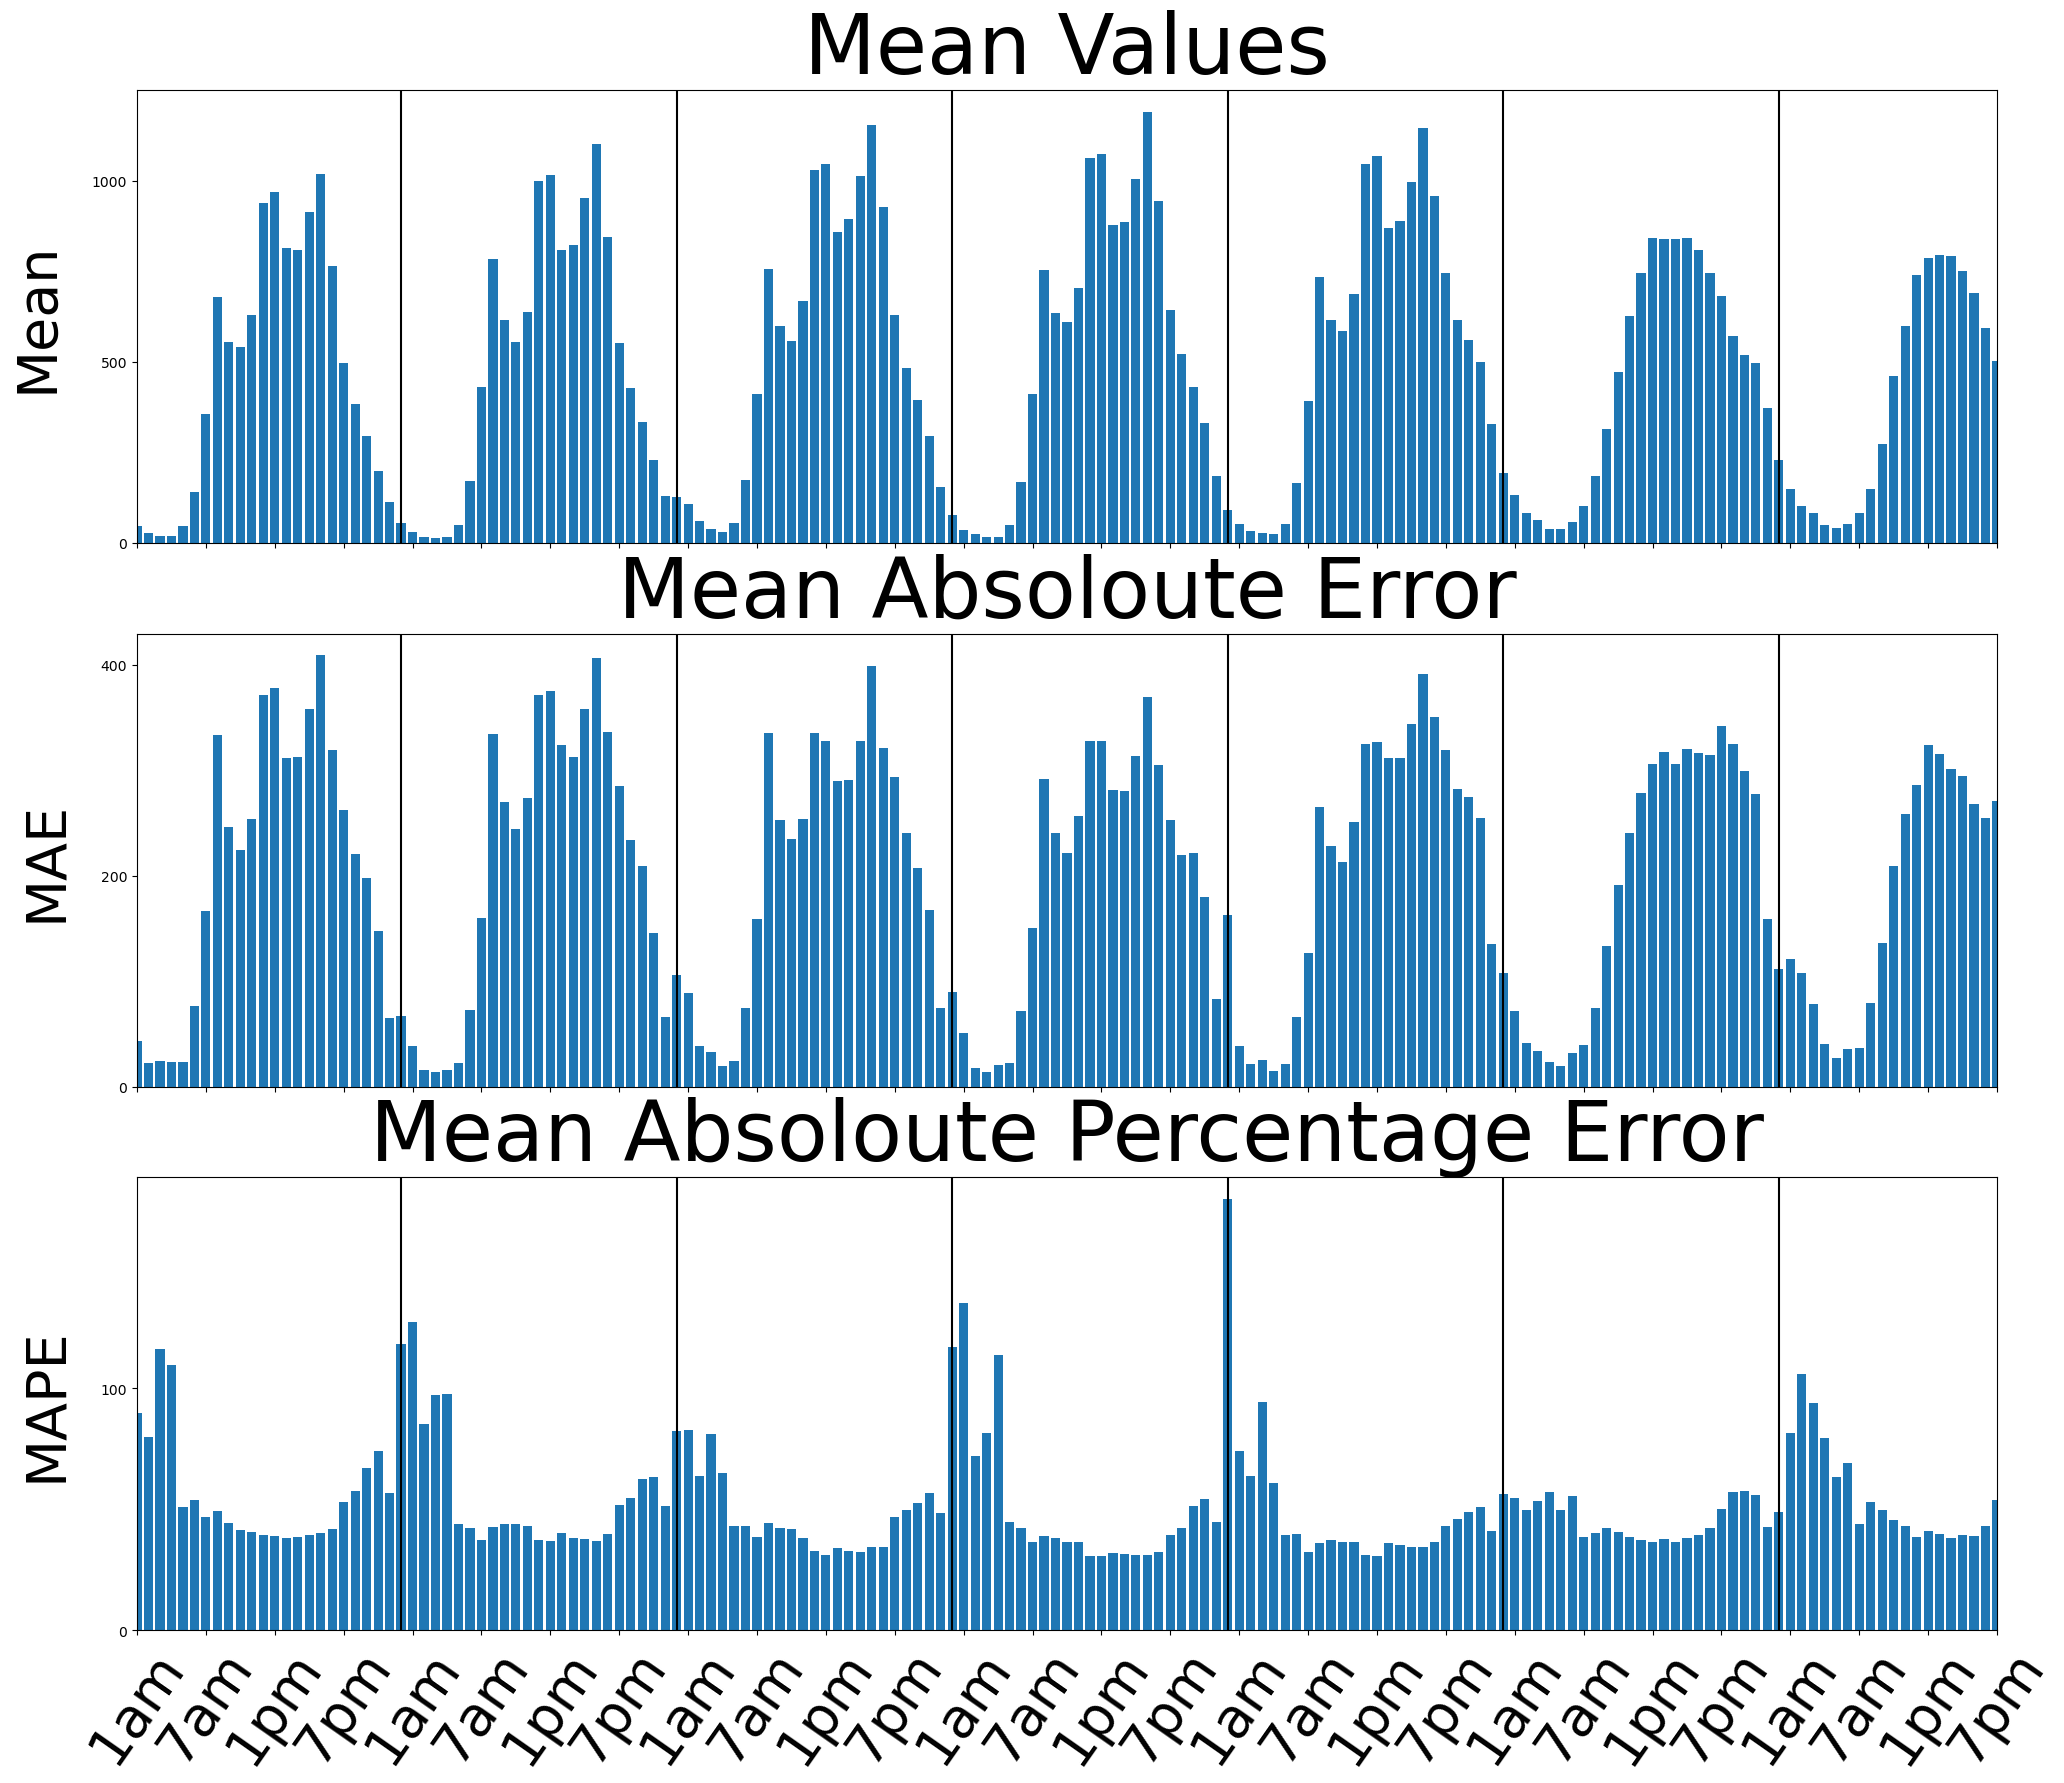

In [33]:
fig,axs =plt.subplots(nrows=3,figsize =(24,20), sharex=True)
axs[0].bar(np.sort(df['hour_of_week'].unique()),hourofweekly_means)#,  yerr=hourofweekly_stds  )
axs[0].set_title('Mean Values', fontsize=60)
axs[1].bar(np.sort(df['hour_of_week'].unique()),hourofweekly_maes)#, yerr=hourofweekly_mae_stds   )
axs[1].set_title('Mean Absoloute Error', fontsize=60)
axs[2].bar(np.sort(df['hour_of_week'].unique()),hourofweekly_mapes )
axs[2].set_title('Mean Absoloute Percentage Error', fontsize=60)
# axs[2].tick_params(axis='x')

# Removes weird whitespace from the start
axs[0].set_xlim([1,len(df['hour_of_week'].unique()[::3])])
axs[1].set_xlim([1,len(df['hour_of_week'].unique()[::3])])
axs[2].set_xlim([1,len(df['hour_of_week'].unique()[::3])])

# Axis labels
axs[2].set_xticks(list(range(1,len(labels)))[::6])
axs[2].set_xticklabels(labels[::6], fontsize=40, rotation = 55)

axs[0].set_ylabel('Mean', fontsize=40, labelpad = 20)
axs[1].set_ylabel('MAE', fontsize=40, labelpad = 20)
axs[2].set_ylabel('MAPE', fontsize=40, labelpad = 20)


params = {'ytick.labelsize': 50}
plt.rcParams.update(params)

for i in range(1,7):
    axs[0].axvline(x = 24*i, color = 'black', label = 'axvline - full height')
    axs[1].axvline(x = 24*i, color = 'black', label = 'axvline - full height')
    axs[2].axvline(x = 24*i, color = 'black', label = 'axvline - full height')

fig.savefig(os.path.join(results_dir, 'Error_by_hour_of_week.pdf'))

### Plot errors by hour of day

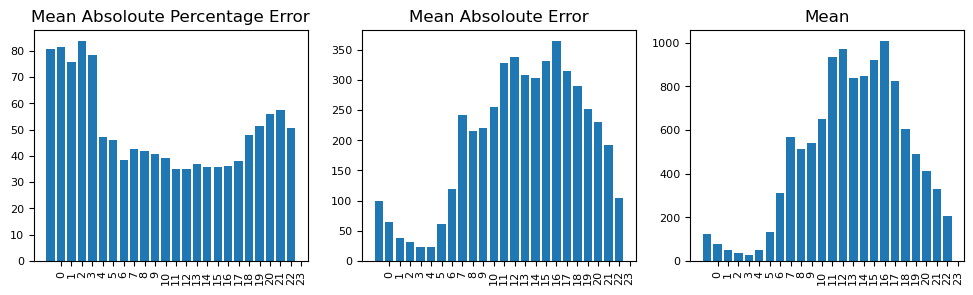

In [34]:
fig,axs =plt.subplots(ncols=3, figsize =(12,3))
axs[0].bar(np.sort(df['Hour'].unique()),hourly_mapes )
axs[0].set_title('Mean Absoloute Percentage Error');
axs[1].bar(np.sort(df['Hour'].unique()),hourly_maes )
axs[1].set_title('Mean Absoloute Error')
axs[2].bar(np.sort(df['Hour'].unique()),hourly_means )
axs[2].set_title('Mean')

axs[0].set_xticks(list(range(1,25)))
axs[0].set_xticklabels(df['Hour'].unique(), rotation=90, size = 8);
axs[1].set_xticks(list(range(1,25)))
axs[1].set_xticklabels(df['Hour'].unique(), rotation=90, size = 8);
axs[2].set_xticks(list(range(1,25)))
axs[2].set_xticklabels(df['Hour'].unique(), rotation=90, size = 8);

axs[2].tick_params(axis='y', which='major', labelsize=8)
axs[0].tick_params(axis='y', which='major', labelsize=8)
axs[1].tick_params(axis='y', which='major', labelsize=8)

### Plot the errors by sensor

In [35]:
### Read in Melbourne sensor location spatial data
melbourne_sensors = pd.read_csv("../Cleaned_data/SensorData/sensor_locations.csv")
melbourne_sensors.rename(columns={'sensor_description': 'Name'}, inplace = True)

In [36]:
sensorly_errors_df = pd.DataFrame({'sensor_id':np.sort(sensor_ids.unique()),'MAPE':sensorly_mapes,'MAE':sensorly_maes,
                                  'Mean':sensorly_means})
sensorly_errors_df.dropna(inplace=True)
melbourne_sensors = pd.merge(sensorly_errors_df, melbourne_sensors, on='sensor_id', how='left')

### Mean

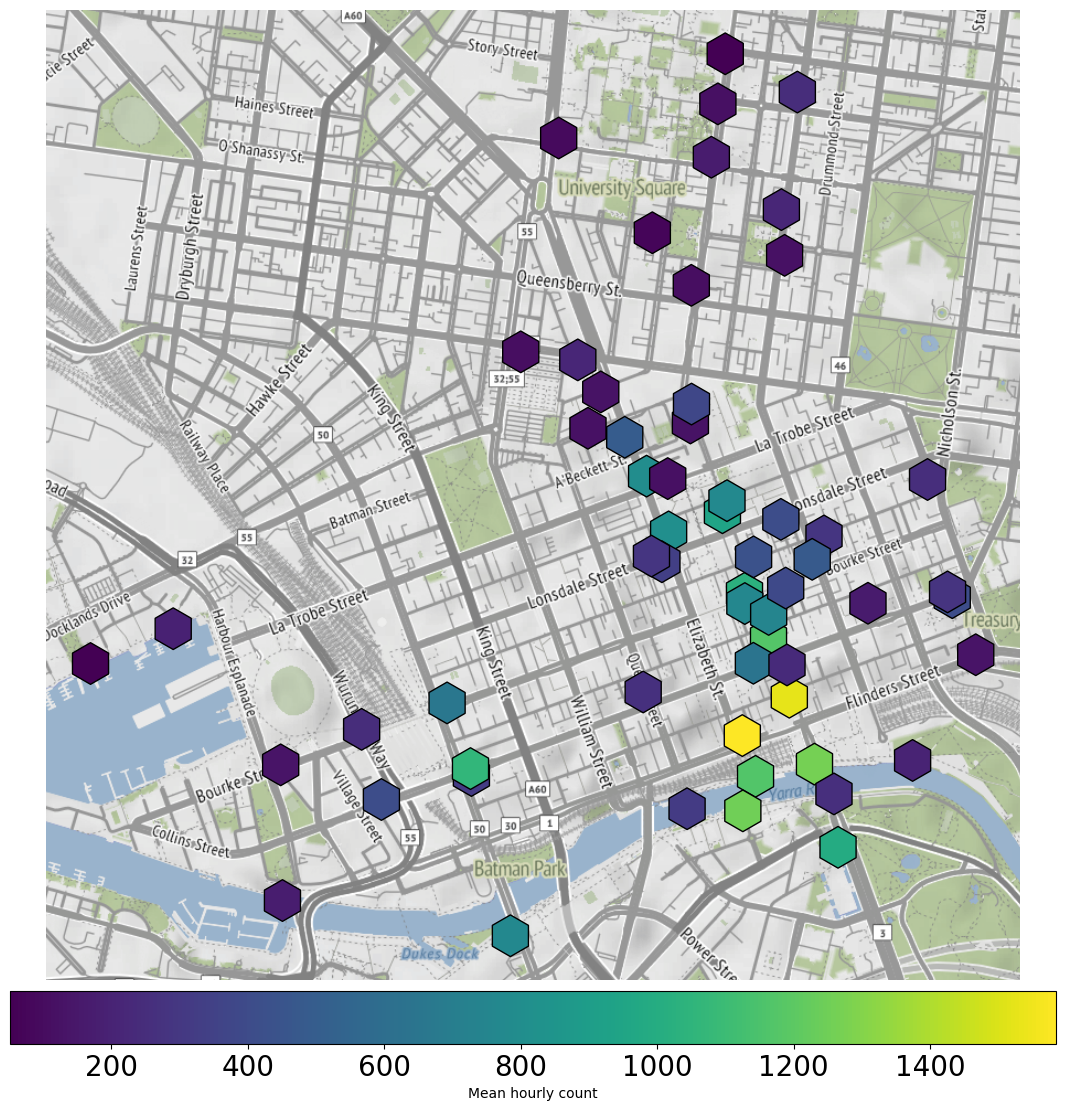

In [37]:
geometry = [Point(xy) for xy in zip(melbourne_sensors.Longitude, melbourne_sensors.Latitude)]
gdf = gpd.GeoDataFrame(melbourne_sensors, geometry=geometry)
gdf = gdf.set_crs('EPSG:4326')
gdf = gdf.to_crs('epsg:3857')

fig, ax = plt.subplots(figsize=(15,15))
gdf.plot(column=gdf.Mean, ax = ax, markersize = 900,edgecolor = 'black', cmap="viridis", marker='h', legend = True,
         legend_kwds={'shrink': 0.9, 'pad':0.01, 'label':'Mean hourly count',
                      "orientation": "horizontal"})

# Change font size on legend
cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=20)
plt.rcParams.update({'font.size': 35}) # legend title size

# gdf2.plot(ax = ax, markersize = 300,color='green')
cx.add_basemap(ax, source='https://tiles.stadiamaps.com/tiles/stamen_terrain/{z}/{x}/{y}{r}.png?api_key='+api)
ax.axis('off')
ax.set_axis_off()

fig.savefig(os.path.join(results_dir, 'SpatialErrors_Mean.png'), bbox_inches='tight')


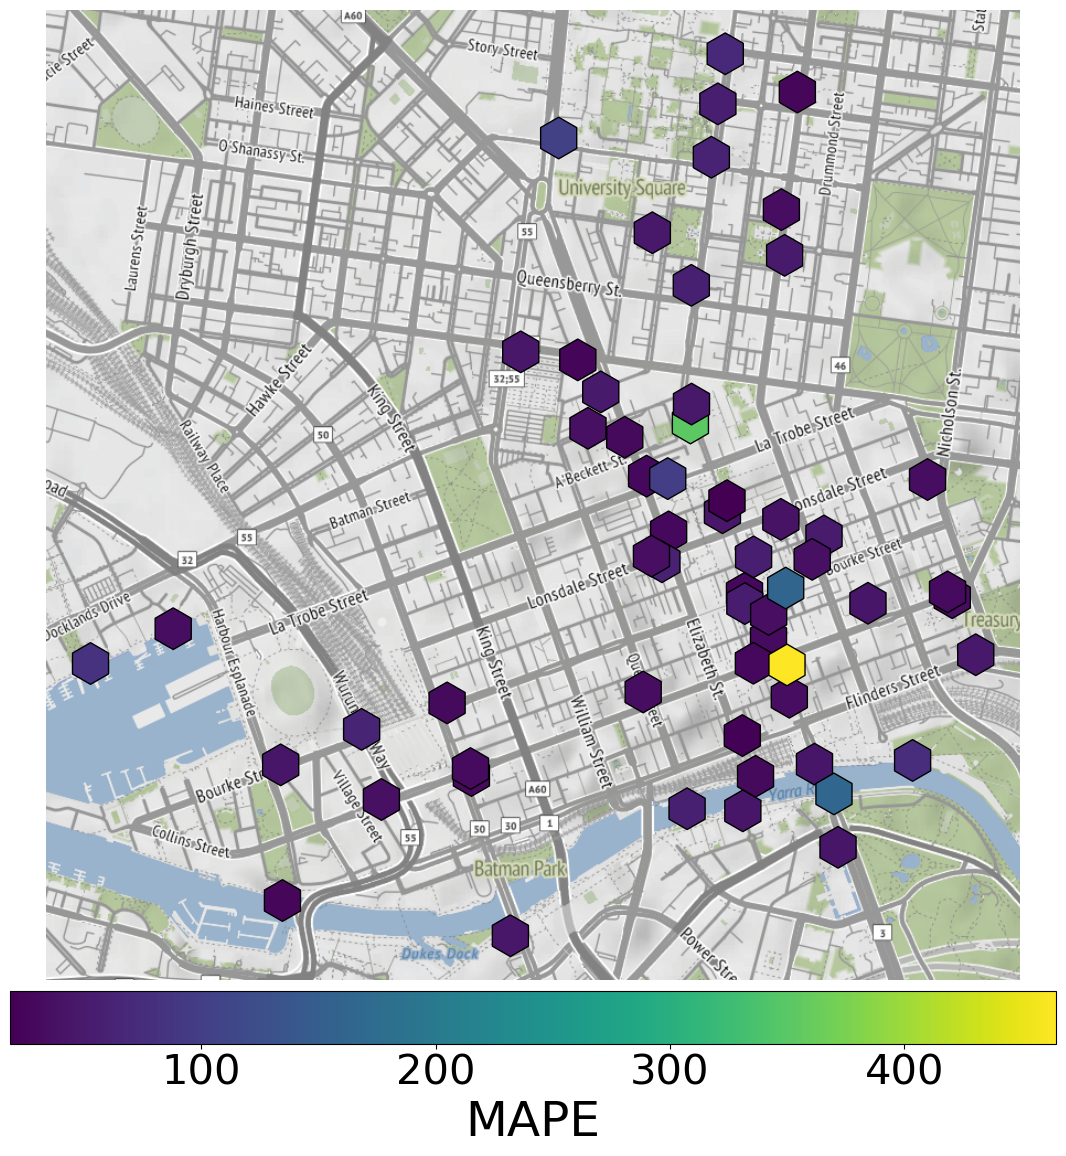

In [38]:
geometry = [Point(xy) for xy in zip(melbourne_sensors.Longitude, melbourne_sensors.Latitude)]
gdf = gpd.GeoDataFrame(melbourne_sensors, geometry=geometry)
gdf = gdf.set_crs('EPSG:4326')
gdf = gdf.to_crs('epsg:3857')

fig, ax = plt.subplots(figsize=(15,15))
gdf.plot(column=gdf.MAPE, ax = ax, markersize = 900,edgecolor = 'black', cmap="viridis", marker='h', legend = True,
         legend_kwds={'shrink': 0.9, 'pad':0.01, 'label':'MAPE',
                      "orientation": "horizontal"})

# Change font size on legend
cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=30)
plt.rcParams.update({'font.size': 35}) # legend title size

# gdf2.plot(ax = ax, markersize = 300,color='green')
cx.add_basemap(ax, source='https://tiles.stadiamaps.com/tiles/stamen_terrain/{z}/{x}/{y}{r}.png?api_key='+api)
ax.axis('off')
ax.set_axis_off()

fig.savefig(os.path.join(results_dir, 'SpatialErrors_MAPE.png'), bbox_inches='tight')

### MAE

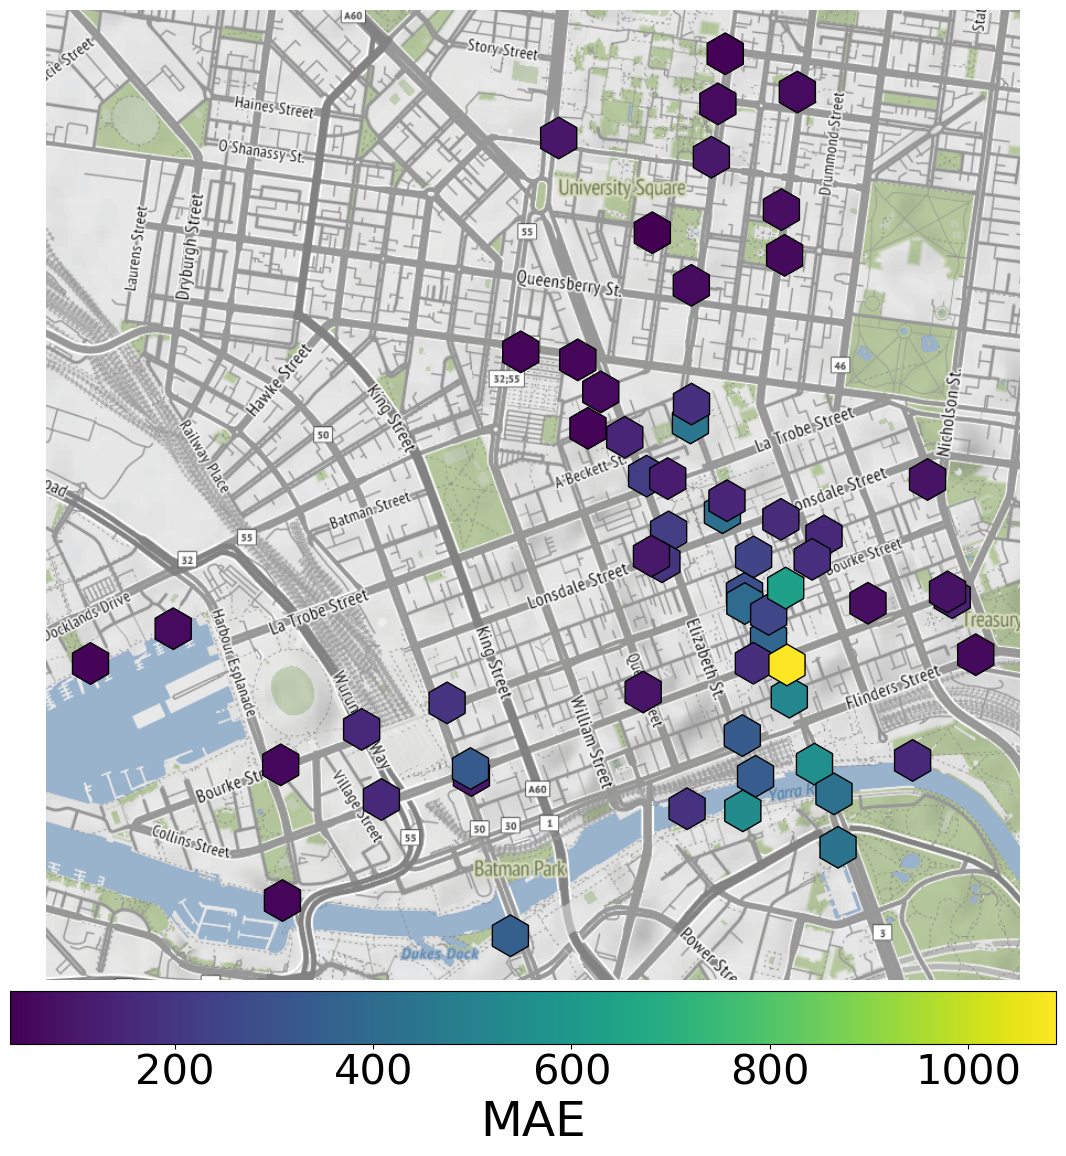

In [39]:
geometry = [Point(xy) for xy in zip(melbourne_sensors.Longitude, melbourne_sensors.Latitude)]
gdf = gpd.GeoDataFrame(melbourne_sensors, geometry=geometry)
gdf = gdf.set_crs('EPSG:4326')
gdf = gdf.to_crs('epsg:3857')

fig, ax = plt.subplots(figsize=(15,15))
gdf.plot(column=gdf.MAE, ax = ax, markersize = 900,edgecolor = 'black', cmap="viridis", marker='h', legend = True,
         legend_kwds={'shrink': 0.9, 'pad':0.01, 'label':'MAE',
                      "orientation": "horizontal"})

# Change font size on legend
cb_ax = fig.axes[1]
cb_ax.tick_params(labelsize=30)
plt.rcParams.update({'font.size': 35}) # legend title size

# gdf2.plot(ax = ax, markersize = 300,color='green')
cx.add_basemap(ax, source='https://tiles.stadiamaps.com/tiles/stamen_terrain/{z}/{x}/{y}{r}.png?api_key='+api)
ax.axis('off')
ax.set_axis_off()

fig.savefig(os.path.join(results_dir, 'SpatialErrors_MAE.png'), bbox_inches='tight')